# Image-text retrieval for museum exhibits

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

import os
import random
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from transformers import AutoTokenizer, AutoModel, ViTModel, ViTFeatureExtractor

%matplotlib inline

In [2]:
def set_seed(SEED):
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    random.seed(SEED)
    np.random.seed(SEED) 
    os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Рассмотрим датасет по ближе

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
print("В обучающей выборке {} запросов".format(len(df_train)))
print("В обучающей выборке {} изображений".format(len(os.listdir("train"))))
print("В тестовой выборке {} запросов".format(len(df_test)))
print("В тестовой выборке {} изображений".format(len(os.listdir("test"))))

В обучающей выборке 2098 запросов
В обучающей выборке 2098 изображений
В тестовой выборке 900 запросов
В тестовой выборке 900 изображений


In [5]:
df_train.head()

,id,description,object_img
0,520,Фотография. Г. Пермь. Здание горисполкома. ПО...,799
1,1817,Фотонегатив пленочный. Труппа театра «У моста»...,854
2,188,"Изразец гладкий расписной ""пермский""- карниз А...",1794


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2098 non-null   int64 
 1   description  2098 non-null   object
 2   object_img   2098 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 49.3+ KB


## Построение датасета

In [7]:
class Text2ImageDataset(Dataset):
    def __init__(self, train_df, test_df):
        """
        Аргументы:
            train_df, test_df (pd.DataFrame): тренировочный и тестовый наборы данных
        """
        self.val_df = train_df.sample(frac=0.1, random_state=42)
        self.val_size = len(self.val_df)
        
        self.train_df = train_df.drop(self.val_df.index)
        self.train_size = len(self.train_df)
        self.test_df = test_df
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train') 
    
    @classmethod
    def load_dataset(cls, tokenizer, feature_extractor, 
                     img_model, txt_model):
        """Загрузка данных датасета
        Аргументы:
            tokenizer: экземпляр векторизатора текстовых данных
            feature_extractor: экземпляр векторизатора изображений
            img_model: модель-трансформер для обработки изображений
            txt_model: модель-трансформер для обработки текстовых данных
        Возвращает:
            экземпляр Text2ImageDataset
        """
        train_df = pd.read_csv("train.csv")
        test_df = pd.read_csv("test.csv")
        
        #векторизация изображений
        img_vecs = []
        img_model.eval()
        img_model.to(device)
        for img_id in train_df['object_img']:
            img = Image.open("train/{}.png".format(img_id))
            img = img.convert('RGB')
            encoding = feature_extractor(images=img, return_tensors='pt').to(device)
            img_vecs.append(
                np.squeeze(np.array(
                    img_model(**encoding)['last_hidden_state'][:, 0].detach().cpu()
                )))
            encoding.to('cpu')
            del encoding
                
        train_df.insert(len(train_df.columns), 'image_vec', img_vecs)
        
        img_vecs = []
        img_ids = []
        img_model.eval()
        img_model.to(device)
        for img_id in os.listdir("test"):
            img = Image.open("test/{}".format(img_id))
            img = img.convert('RGB')
            encoding = feature_extractor(images=img, return_tensors='pt').to(device)
            img_vecs.append(
                np.squeeze(np.array(
                    img_model(**encoding)['last_hidden_state'][:, 0].detach().cpu()
                )))
            img_ids.append(int(img_id[:-4]))
            encoding.to('cpu')
            del encoding
        
        test_df.insert(len(test_df.columns), 'object_img', img_ids)
        test_df.insert(len(test_df.columns), 'image_vec', img_vecs)        
        
        img_model.to('cpu')
        del img_model
        
        #векторизация текста
        txt_vecs = []
        txt_model.eval()
        txt_model.to(device)
        for txt in train_df['description']:
            vec = tokenizer(txt, max_length = 128, padding = 'max_length', 
                            truncation = True, return_tensors='pt').to(device)
            txt_vecs.append(
                np.squeeze(np.array(
                    txt_model(**vec)['last_hidden_state'][:, 0].detach().cpu()
                )))
            vec.to('cpu')
            del vec
                
        train_df.insert(len(train_df.columns), 'text_vec', txt_vecs)
        
        txt_vecs = []
        txt_model.eval()
        txt_model.to(device)
        for txt in test_df['description']:
            vec = tokenizer(txt, max_length = 128, padding = 'max_length', 
                            truncation = True, return_tensors='pt').to(device)
            txt_vecs.append(
                np.squeeze(np.array(
                    txt_model(**vec)['last_hidden_state'][:, 0].detach().cpu()
                )))
            vec.to('cpu')
            del vec
        
        test_df.insert(len(test_df.columns), 'text_vec', txt_vecs)
        
        txt_model.to('cpu')
        del txt_model
        
        return cls(train_df, test_df)

    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
        Аргументы:
            split (str): "train"/"val"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        
        return {"txt": row['text_vec'],
                "img": row['image_vec'],
                "img_id": row['object_img'],
                "txt_id": row['id']}

    def __len__(self):
        return self._target_size

In [10]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
txt_model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
img_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
dataset = Text2ImageDataset.load_dataset(tokenizer, feature_extractor, 
                                         img_model, txt_model)
dataset.train_df.head()

,id,description,object_img,image_vec,text_vec
0,520,Фотография. Г. Пермь. Здание горисполкома. ПО...,799,"[0.103668034, -0.015063661, -0.016073922, 0.11...","[0.08067136, -0.08095811, -0.32000762, 0.01341..."
1,1817,Фотонегатив пленочный. Труппа театра «У моста»...,854,"[-0.24575898, -0.24284588, 0.045937497, 0.3451...","[0.22202191, -0.044875465, -0.023288388, -0.19..."
2,188,"Изразец гладкий расписной ""пермский""- карниз А...",1794,"[0.18985553, -0.33419284, 0.21572828, -0.09138...","[0.24180464, -0.08063073, 0.23322548, -0.23405..."
3,1472,Фотонегатив пленочный. Серебряная чаша из Хоре...,526,"[-0.2634475, -0.308959, 0.11753492, -0.2709597...","[0.3505719, -0.16521649, 0.36884767, -0.053718..."
4,1664,Фотонегатив стеклянный. Этнография коми-пермяк...,244,"[0.04096296, 0.118398026, -0.15346594, 0.17163...","[0.20113145, -0.20383996, 0.29824924, 0.133582..."


In [12]:
dataset.test_df.head()

,id,description,object_img,image_vec,text_vec
0,486,Фотография. Елизавета Алексеевна Юманова. ПКМ...,1002,"[-0.018491829, 0.012447446, -0.011537282, 0.09...","[0.20602532, -0.0075206566, -0.08344607, 0.088..."
1,813,Фотография. Заседание комитета комсомола мотор...,1005,"[0.041885503, 0.20836398, -0.27797422, -0.0293...","[0.056039162, 0.064530075, -0.15065418, -0.013..."
2,2980,"Фотография. День ""Саланга"". ПОКМ-18530/638 фо...",101,"[0.22351311, -0.10364469, 0.082243726, 0.03772...","[-0.16495973, -0.082818106, -0.10660107, -0.01..."
3,13,Фотография. Елизавета Алексеевна Юманова. ПКМ...,1011,"[-0.22248544, -0.082798034, 0.27187175, -0.019...","[0.20947313, -0.0038510114, -0.09402984, 0.099..."
4,2467,"Фотография. ""Универмаг Пермь. Оформление демон...",1014,"[0.089719675, -0.10408112, -0.018355599, -0.08...","[-0.24177192, -0.09324892, -0.25142977, -0.215..."


In [8]:
def generate_batches(dataset, batch_size, shuffle=True, 
                     drop_last=True, device="cpu"):
    """
        Функция-генератор - адаптер для объекта Dataloader фреймворка PyTorch.
        Гарантирует размещение всех тензоров на нужном устройстве.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, 
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Построение модели

In [6]:
class Text2ImageModel(nn.Module):
    def __init__(self, output_eol_dim, input_dim=768):
        super(Text2ImageModel, self).__init__()
        
        self.eol_txt = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, output_eol_dim)
        )
        
        self.eol_img = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, output_eol_dim)
        )

        self.softmax = nn.Softmax(dim=0)
 
    def forward(self, eol_txt_inputs, eol_img_inputs):
        similarity = torch.inner(self.eol_txt(eol_txt_inputs),
                                 self.eol_img(eol_img_inputs))
        txt2img_similarity = self.softmax(similarity)
        img2txt_similarity = self.softmax(torch.transpose(similarity, 0, 1))
        return txt2img_similarity, img2txt_similarity

In [9]:
class HierarchicalRetrievalLoss(nn.Module):
    def __init__(self):
        super(HierarchicalRetrievalLoss, self).__init__()
        
    def forward(self, txt2img_sims, target_imgs, img2txt_sims, target_txts):
        loss = (F.cross_entropy(txt2img_sims, target_imgs) +
              F.cross_entropy(img2txt_sims, target_txts)) / 2
        return loss

In [13]:
def compute_accuracy(ids, target, pred):
    y_true = [ids[i] for i in target]
    y_pred = [ids[i] for i in pred]
    return r2_score(y_true, y_pred)

In [14]:
def pred(prob):
    n = len(prob)
    pred = np.zeros(n, dtype=int)
    for _ in range(n):
        idx = torch.argmax(prob)
        i = int(idx) // n
        j = int(idx) % n
        pred[i] = j
        prob[i] -= 1
        prob[:, j] -= 1
    return pred

## Обучение модели

In [103]:
set_seed(42)
model = Text2ImageModel(output_eol_dim=256)
model.to(device)

loss_func = HierarchicalRetrievalLoss()
optimizer = optim.AdamW(model.parameters(), lr=9e-5)
epoch = 150
batch_size = 32
flag = True
        
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for _ in trange(epoch, desc='iter'):
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)
    
    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for idx, batch in enumerate(batch_generator):
        optimizer.zero_grad()

        t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
        loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                         i2t_sims, torch.arange(len(batch["img"])).to(device))
            
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (idx + 1)
        
        acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                     torch.arange(len(batch["img"])),
                                     pred(t2i_sims.cpu()))
        running_acc += (acc_batch - running_acc) / (idx + 1)
        
        loss.backward()
        optimizer.step()

    train_loss.append(running_loss)
    train_acc.append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=len(dataset),
                                       shuffle=False, drop_last=False, 
                                       device=device)
    
    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    for idx, batch in enumerate(batch_generator):

        t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
        loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                         i2t_sims, torch.arange(len(batch["img"])).to(device))
            
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (idx + 1)
        
        acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                     torch.arange(len(batch["img"])),
                                     pred(t2i_sims.cpu()))
        running_acc += (acc_batch - running_acc) / (idx + 1)

    val_loss.append(running_loss)
    val_acc.append(running_acc)
    
    if running_acc > 0.8 and flag:
        optimizer = optim.SGD(model.parameters(), lr=5e-6)
        flag = False

iter:   0%|          | 0/150 [00:00<?, ?it/s]

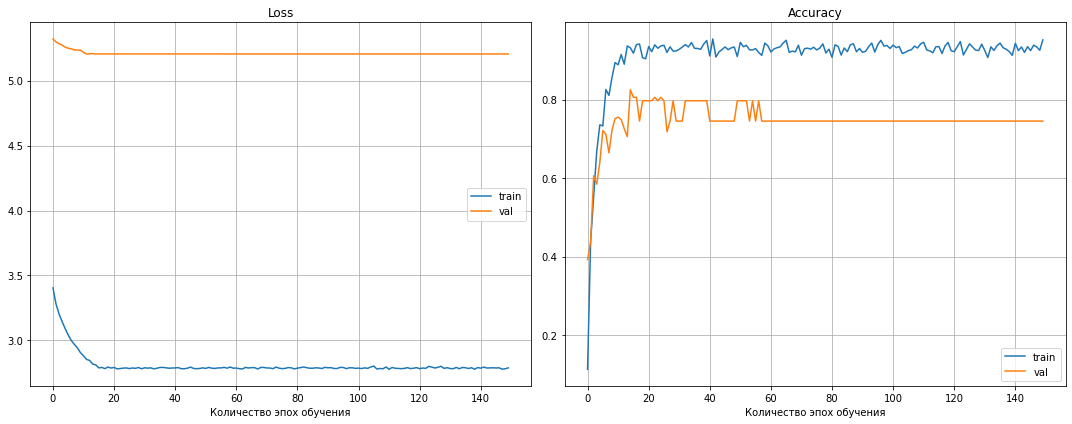

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), )

ax[0].plot(np.arange(len(train_loss)), train_loss, label='train')
ax[0].plot(np.arange(len(val_loss)), val_loss, label='val')

ax[1].plot(np.arange(len(train_acc)), train_acc, label='train')
ax[1].plot(np.arange(len(val_acc)), val_acc, label='val')
    
ax[0].set_xlabel('Количество эпох обучения')
ax[1].set_xlabel('Количество эпох обучения')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)

fig.tight_layout()
plt.show()

## Вычисление результата

In [105]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=len(dataset),
                                   shuffle=False, drop_last=False,
                                   device=device)
subm_df = pd.DataFrame()
model.eval()

for idx, batch in enumerate(batch_generator):

    t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
    img_ids = np.array(batch['img_id'].detach().cpu())
    subm_df.insert(len(subm_df.columns), 'id', batch['txt_id'].detach().cpu())
    subm_df.insert(len(subm_df.columns), 'object_img', [img_ids[i] for i in pred(t2i_sims.cpu())])

In [72]:
subm_df.to_csv('submission5.csv', index=False)
subm_df.head()

,id,object_img
0,486,1389
1,813,1651
2,2980,611
3,13,1534
4,2467,365


In [109]:
first_txt_sims = np.copy(t2i_sims[20].detach().cpu())
img_ids = batch['img_id'].detach().cpu()
img_ids_top = []
for _ in range(10):
    i = int(np.argmax(first_txt_sims))
    img_ids_top.append(int(img_ids[i]))
    first_txt_sims[i] = 0
print(df_test["description"][20])
print(img_ids_top)

Фотонегатив стеклянный. Группа людей на природе. ДИ/Н-1247 ПОКМ-11572/133 фотосъемка,стекло     Изображение хаотично стоящих и сидящих возле куста и на поляне людей.
[928, 930, 455, 926, 228, 949, 1292, 923, 193, 618]


## Эксперименты

### LR AdamW

In [38]:
max_acc = []
for lr in [1e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 5e-4]:
    set_seed(42)
    model = Text2ImageModel(output_eol_dim=256)
    model.to(device)

    loss_func = HierarchicalRetrievalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    epoch = 200
    batch_size = 32
    flag = True

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for _ in trange(epoch, desc='iter'):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

            loss.backward()
            optimizer.step()

        train_loss.append(running_loss)
        train_acc.append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset),
                                           shuffle=False, drop_last=False, 
                                           device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.eval()

        for idx, batch in enumerate(batch_generator):

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

        val_loss.append(running_loss)
        val_acc.append(running_acc)
        
    i = np.argmax(val_acc)
    max_acc.append((i, val_acc[i]))

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]

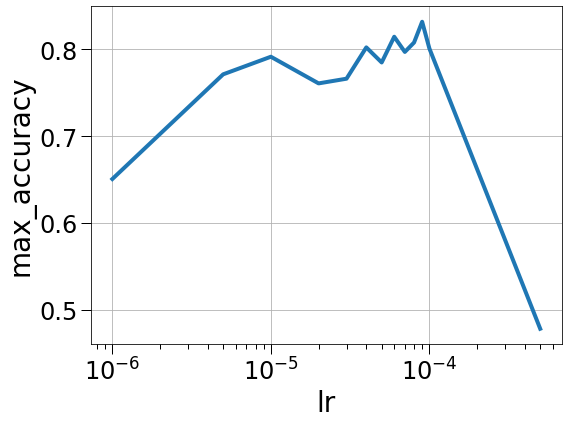

In [40]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.plot([1e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4, 5e-4], 
        np.array(max_acc)[:, 1], lw=4)
    
ax.set_xlabel('lr', fontsize=28)
ax.set_ylabel('max_accuracy', fontsize=28)

#ax.legend()
ax.set_xscale('log')
ax.grid(True)

ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)

fig.tight_layout()
plt.show()

In [41]:
print(max_acc)

[(142, 0.6506301688428096), (133, 0.7713642360133314), (84, 0.7916564163385647), (49, 0.7609201815516379), (40, 0.7663224570947877), (35, 0.8024319619493214), (58, 0.7850417027605016), (21, 0.8147038535704823), (20, 0.797198694238213), (15, 0.8080111434216417), (19, 0.8320012586087082), (17, 0.8011399019381347), (2, 0.477954906908893)]


### LR SGD

In [101]:
val_acc_SGD_lr = []
for lr in [9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]:
    set_seed(42)
    model = Text2ImageModel(output_eol_dim=256)
    model.to(device)

    loss_func = HierarchicalRetrievalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=9e-5)
    epoch = 150
    batch_size = 32
    flag = True

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for _ in trange(epoch, desc='iter'):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

            loss.backward()
            optimizer.step()

        train_loss.append(running_loss)
        train_acc.append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset),
                                           shuffle=False, drop_last=False, 
                                           device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.eval()

        for idx, batch in enumerate(batch_generator):

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

        val_loss.append(running_loss)
        val_acc.append(running_acc)
        
        if running_acc > 0.83 and flag:
            optimizer = optim.SGD(model.parameters(), lr=lr)
            flag = False
            
    val_acc_SGD_lr.append(val_acc)

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

iter:   0%|          | 0/150 [00:00<?, ?it/s]

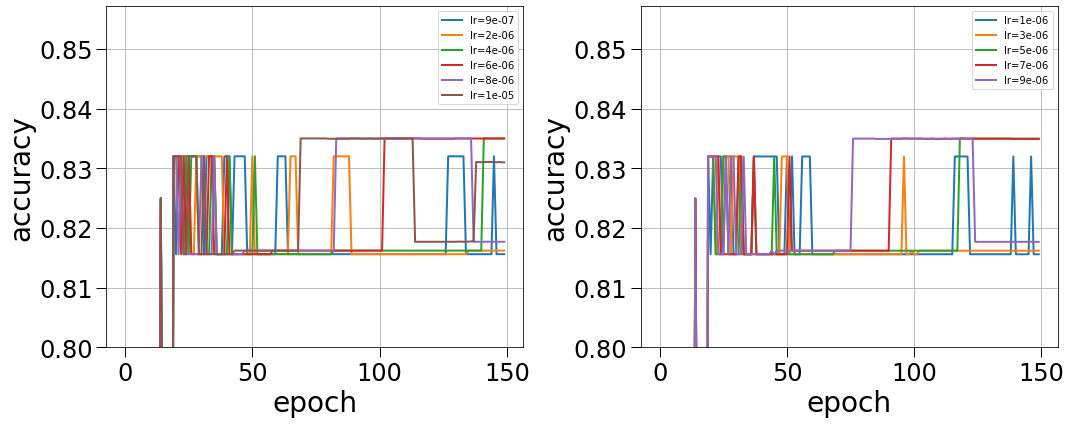

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

lrs = [9e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5]

for i in range(0, len(lrs), 2):
    ax[0].plot(val_acc_SGD_lr[i], lw=2, label='lr={}'.format(lrs[i]))
    
for i in range(1, len(lrs), 2):
    ax[1].plot(val_acc_SGD_lr[i], lw=2, label='lr={}'.format(lrs[i]))
    
ax[0].set_xlabel('epoch', fontsize=28)
ax[0].set_ylabel('accuracy', fontsize=28)

ax[0].legend()
#ax.set_xscale('log')
ax[0].grid(True)

ax[0].tick_params(labelsize=24, length=10, width=1)
ax[0].tick_params(which='minor', length=5, width=1)
ax[0].set_ylim(bottom=0.8)

ax[1].set_xlabel('epoch', fontsize=28)
ax[1].set_ylabel('accuracy', fontsize=28)

ax[1].legend()
#ax.set_xscale('log')
ax[1].grid(True)

ax[1].tick_params(labelsize=24, length=10, width=1)
ax[1].tick_params(which='minor', length=5, width=1)
ax[1].set_ylim(bottom=0.8)

fig.tight_layout()
plt.show()

In [50]:
val_acc_SGD_lr2 = []
for lr in [3e-6, 4e-6, 5e-6]:
    set_seed(42)
    model = Text2ImageModel(output_eol_dim=256)
    model.to(device)

    loss_func = HierarchicalRetrievalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=9e-5)
    epoch = 1000
    batch_size = 32
    flag = True

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for _ in trange(epoch, desc='iter'):
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

            loss.backward()
            optimizer.step()

        train_loss.append(running_loss)
        train_acc.append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=len(dataset),
                                           shuffle=False, drop_last=False, 
                                           device=device)

        running_loss = 0.0
        running_acc = 0.0
        model.eval()

        for idx, batch in enumerate(batch_generator):

            t2i_sims, i2t_sims = model(batch["txt"], batch["img"])
            loss = loss_func(t2i_sims, torch.arange(len(batch["txt"])).to(device), 
                             i2t_sims, torch.arange(len(batch["img"])).to(device))

            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (idx + 1)

            acc_batch = compute_accuracy(batch['img_id'].cpu(),
                                         torch.arange(len(batch["img"])),
                                         pred(t2i_sims.cpu()))
            running_acc += (acc_batch - running_acc) / (idx + 1)

        val_loss.append(running_loss)
        val_acc.append(running_acc)
        
        if running_acc > 0.83 and flag:
            optimizer = optim.SGD(model.parameters(), lr=lr)
            flag = False
            
    val_acc_SGD_lr2.append(val_acc)

iter:   0%|          | 0/1000 [00:00<?, ?it/s]

iter:   0%|          | 0/1000 [00:00<?, ?it/s]

iter:   0%|          | 0/1000 [00:00<?, ?it/s]

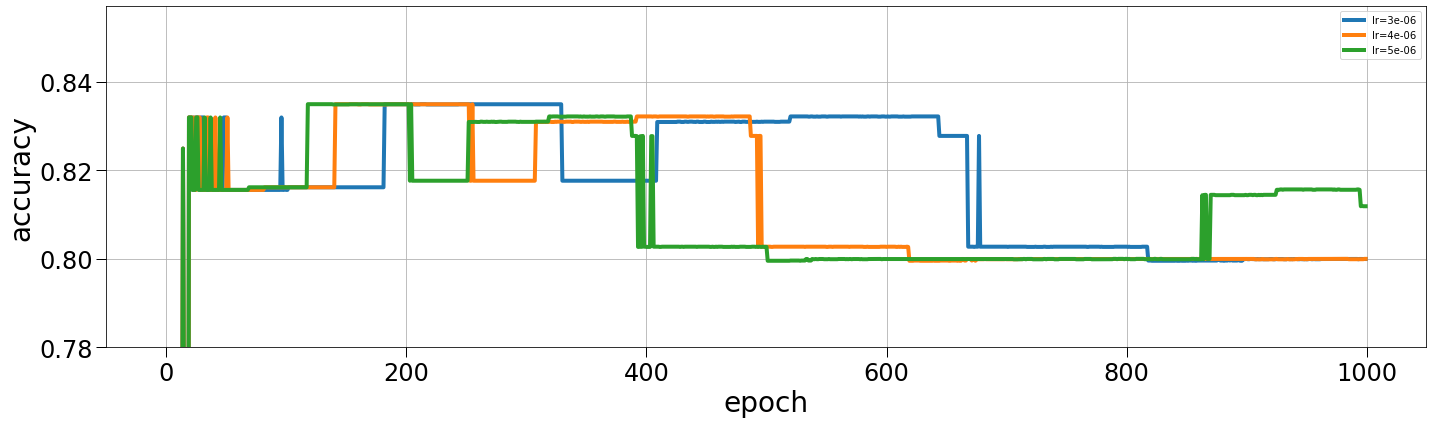

In [56]:
fig, ax = plt.subplots(1, figsize=(20, 6))

lrs = [3e-6, 4e-6, 5e-6]

for i in range(len(lrs)):
    ax.plot(val_acc_SGD_lr2[i], lw=4, label='lr={}'.format(lrs[i]))
    
ax.set_xlabel('epoch', fontsize=28)
ax.set_ylabel('accuracy', fontsize=28)

ax.legend()
#ax.set_xscale('log')
ax.grid(True)

ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.set_ylim(bottom=0.78)

fig.tight_layout()
plt.show()